In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from joblib import dump,load
from sklearn.preprocessing import StandardScaler
# Import scoring metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [195]:
df_temp = pd.read_pickle('./clean_data/clean_data_dataframe.zip')

In [196]:
# Define a 'basic' dataframe that only predicts off LendingClub sub_grade feature
df_basic= df_temp[['loan_status','sub_grade']]

# Select a grade to look at 

# Only look at low grades, high interest
#df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('B' in element))]

df_temp.drop(columns = 'sub_grade', inplace = True)

In [197]:
rfc = 0
lm = 0
gnb = 0
mlp = 0
gbc = 0 

In [198]:
# Load models
model_filepath = './models/'
rfc = load('../rfc_model/rfc.pkl')
lm = load(model_filepath + 'lm.pkl')
gbc = load(model_filepath + 'gbc.pkl')


In [323]:
rfc.feature_importances_

array([0.        , 0.02362232, 0.00397737, 0.0026211 , 0.00253588,
       0.00217319, 0.00209244, 0.00208675, 0.00216354, 0.00221715,
       0.00195469, 0.00277407, 0.00302818, 0.00221367, 0.00330439,
       0.00417066, 0.00341449, 0.00320755, 0.00378547, 0.00158804,
       0.00039733, 0.00098147, 0.00080819, 0.00062632, 0.00168706,
       0.00009929, 0.00111762, 0.00043454, 0.00000027, 0.00115622,
       0.00091958, 0.00144158, 0.00310311, 0.0011089 , 0.00095111,
       0.00025446, 0.00039418, 0.00254957, 0.00153394, 0.0005813 ,
       0.        , 0.        , 0.00169139, 0.001181  , 0.00056484,
       0.0008691 , 0.001053  , 0.00143353, 0.00150173, 0.        ,
       0.00144872, 0.00137498, 0.0012497 , 0.00073438, 0.00039349,
       0.00159173, 0.00043405, 0.00190693, 0.00068329, 0.00117111,
       0.00291597, 0.00172404, 0.00094008, 0.00077404, 0.00191351,
       0.00045509, 0.00075117, 0.0003177 , 0.00128479, 0.00247797,
       0.000639  , 0.00180781, 0.00020891, 0.0011056 , 0.00096

In [210]:
# Helper functions
def patsy_string_from_df(df,target_string):
    """Makes patsy string from dataframe df. Drops target_string column by default."""
    df = df.drop(columns = [target_string]) # Drop the target variable
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

def make_confusion_matrix(model, X_test , y_test, threshold=.5, plot = False):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)
    #mat_confusion = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    if plot:
        plt.figure(dpi=80)
        plt.figure(figsize=(8, 8))
        sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
               xticklabels=['Paid off', 'Defaulted'],
               yticklabels=['Paid off', 'Defaulted']);
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.title(str(type(model)))
    return mat_confusion




array(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi

In [212]:
with open('model_labels.pkl', 'rb') as handle:
    b = pickle.load(handle)
print(b)

['loan_amnt' 'term' 'installment' 'emp_length' 'home_ownership'
 'annual_inc' 'verification_status' 'purpose' 'addr_state' 'dti'
 'delinq_2yrs' 'inq_last_6mths' 'mths_since_last_delinq' 'open_acc'
 'pub_rec' 'revol_bal' 'total_acc' 'acc_now_delinq' 'tot_coll_amt'
 'tot_cur_bal' 'total_rev_hi_lim' 'acc_open_past_24mths' 'avg_cur_bal'
 'bc_open_to_buy' 'bc_util' 'chargeoff_within_12_mths'
 'mo_sin_old_il_acct' 'mo_sin_old_rev_tl_op' 'mo_sin_rcnt_rev_tl_op'
 'mo_sin_rcnt_tl' 'mort_acc' 'mths_since_recent_bc'
 'mths_since_recent_bc_dlq' 'mths_since_recent_revol_delinq'
 'num_accts_ever_120_pd' 'num_actv_bc_tl' 'num_actv_rev_tl' 'num_bc_sats'
 'num_bc_tl' 'num_il_tl' 'num_op_rev_tl' 'num_rev_accts'
 'num_rev_tl_bal_gt_0' 'num_sats' 'num_tl_90g_dpd_24m'
 'num_tl_op_past_12m' 'pct_tl_nvr_dlq' 'percent_bc_gt_75'
 'pub_rec_bankruptcies' 'tax_liens' 'tot_hi_cred_lim' 'total_bal_ex_mort'
 'total_bc_limit' 'total_il_high_credit_limit' 'disbursement_method'
 'int_rate_percent' 'revol_util_percent' 

In [213]:
X = patsy.dmatrix(patsy_string_from_df(df_temp,'loan_status'),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
# Standardize for models that nead standardization variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

# Standardize all for simplicity
X_train = X_train_standard
X_test = X_test_standard

Xb = patsy.dmatrix(patsy_string_from_df(df_basic,'loan_status'),df_basic)
yb = df_basic['loan_status'].values
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=123456)

In [352]:
test_list = [[5,5],[6,3]]

In [358]:
tuples_test = (5,6)

In [359]:
tuples_test[0]

5

In [378]:
feature_importance_df = pd.DataFrame(sorted_by_second)

In [424]:
feature_labels = df_temp.drop(columns = ['loan_status']).columns.values
# Dump labels to values
#with open('model_labels.pkl', 'wb') as handle:
#    pickle.dump(feature_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
#for item1,item2 in zip(X.design_info.column_names,rfc.feature_importances_):
#    print(f'{item1} has a score of {item2}')
feature_importance_array = zip(X.design_info.column_names,rfc.feature_importances_)
feature_importance_list=list(feature_importance_array)
sorted_by_second = sorted(feature_importance_list, key=lambda tup: tup[1],reverse = True)
#sorted(feature_importance_list)
#plt.bar(X.design_info.column_names,rfc.feature_importances_)
sorted_by_second
num_plot_rows = 5


In [432]:
len(ax.get_xticks())

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])

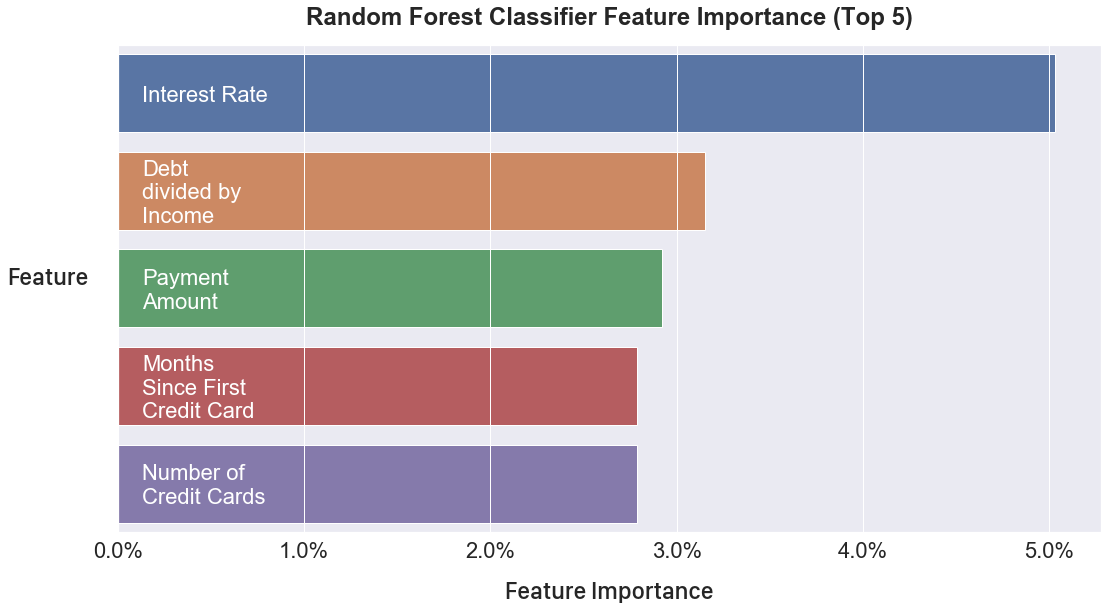

In [475]:
fig, ax = plt.subplots(figsize=(16,9))
# Legible labels
new_labels = ['Interest Rate','Debt\ndivided by\nIncome','Payment\nAmount','Months\nSince First\nCredit Card','Number of\nCredit Cards']
sns.barplot(feature_importance_df[1][:5],new_labels)

# Labels and Tick manipulation
ax.set_xlabel("Feature Importance",fontname = '.SF Compact Display',fontsize=24,fontweight = 'bold',labelpad = 20)
ax.set_ylabel("Feature",fontname = '.SF Compact Display',
              fontsize=24,fontweight = 'bold',rotation = 0,labelpad = 70)

# Move yticks into bars
ax.set_yticklabels(new_labels,color='white',horizontalalignment = 'left')
ax.tick_params(axis='y', which='major', pad=-30)

# Set ytick labels to be above the bars (Also forces grid above bars as well)
ax.set_axisbelow(False) 

# Turn ticks into percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])

plt.title('Random Forest Classifier Feature Importance (Top 5)',pad = 20, fontweight = 'bold')
plt.tight_layout()
plt.savefig('./graphs/feature_importance.png', dpi=300, bbox_inches = "tight")

In [ ]:
# Fit random forest to basic model (sub_grade only)
rfc_b = RandomForestClassifier()
rfc_b.fit(Xb_train,yb_train)
predicted_b = rfc_b.predict(Xb_test)

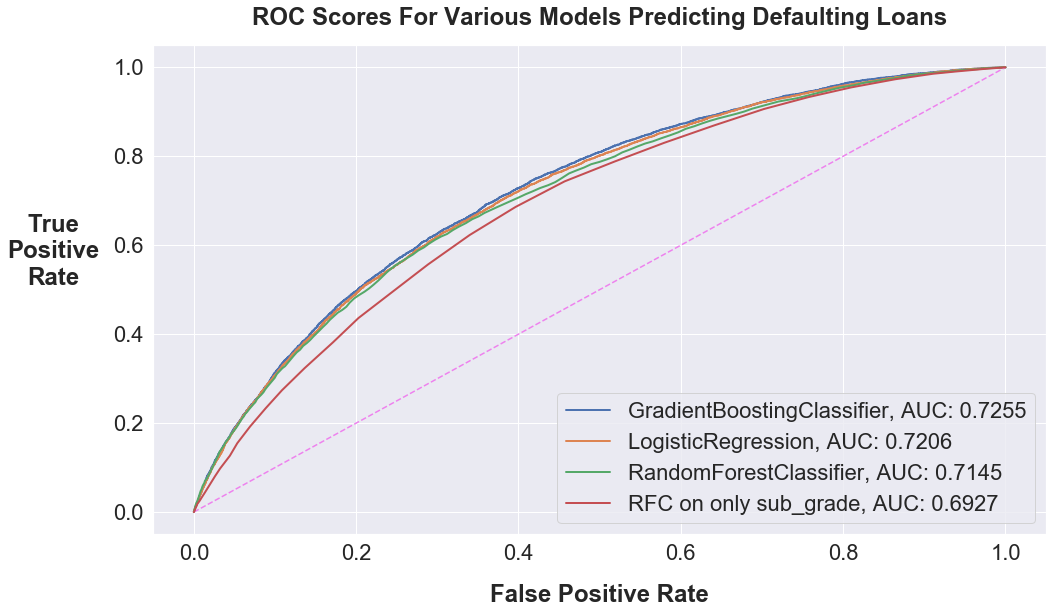

In [480]:

all_models = [rfc,lm,gnb,mlp, gbc]
all_models = [gbc,mlp,gnb,lm,rfc]
models = [ele for ele in all_models if ele]

plt.figure(figsize=(16, 9))
def plot_models():
    ''' Plots all models in the models list defined above. Also plots a dotted line\
    representing the curve of a random model.'''
    model_info=list()
    for model in models:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        f1 = f1_score(y_test,model.predict(X_test))
        model_info.append((model, auc_score,f1))
        plt.plot(fpr, tpr,lw=2, label = str(model)[:str(model).find('(')] + ', AUC: ' + str(auc_score)[:6])
    
    #Random guess line
    



    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    
    plt.xlabel('False Positive Rate',fontweight = 'bold',labelpad = 20)
    plt.ylabel('True\nPositive\nRate',rotation = 0, labelpad = 60,fontweight = 'bold')
    plt.title('ROC Scores For Various Models Predicting Defaulting Loans',fontweight = 'bold',pad = 20);
    return model_info
test = plot_models()
fpr_b,tpr_b,thresholds = roc_curve(yb_test, rfc_b.predict_proba(Xb_test)[:,1])
plt.plot(fpr_b,tpr_b,lw=2, label = 'RFC on only sub_grade' +\
        ', AUC: ' + str(roc_auc_score(yb_test, rfc_b.predict_proba(Xb_test)[:,1]))[:6])
plt.legend(loc='lower right')
plt.savefig('./graphs/ROC_curves_all.png', dpi=300, bbox_inches = "tight")

        

# Cost function to optimize threshold

(Loans classified as defaulted but fully paid off * average paid off loan amount ) - 
(loans classified as paid off but defaulted * average loss to defaulted loan amount)



## Calculate some metrics relative to LC and loans

In [216]:
df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
df.shape

df_gain = df.loc[df['loan_status'] == 'Fully Paid']

# How much does LC fund their loans?

df_lc_funds = (df_gain.loc[df_gain['loan_amnt'] != df_gain['funded_amnt_inv']])
df_lc_funds['lc_funds']= df_lc_funds['funded_amnt'] - df_lc_funds['funded_amnt_inv']
print('LC average contribution to loans in 2014: $' + str(round(df_lc_funds['lc_funds'].mean(),2)))
print('LC total contributions to loans in 2014: $' + str(round(df_lc_funds['lc_funds'].mean()*df_lc_funds.shape[0],2)))

LC average contribution to loans in 2014: $66.42
LC total contributions to loans in 2014: $875525.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## Find Average gains and losses on misclassified loans

In [217]:
# Find average gains per successful loan
df_gain = df.loc[df['loan_status'] == 'Fully Paid']
df_gain = df_gain[['loan_amnt',
        'total_pymnt',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp','total_pymnt_inv']]
df_gain['total_gain'] = df_gain['total_rec_int'] + df_gain['total_rec_late_fee']
average_gain_per_successful_loan = df_gain['total_rec_int'].mean()

# Find average loss per charged off loan
df_loss=df.loc[df['loan_status'] == 'Charged Off']
df_loss = df[['loan_amnt',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'settlement_amount']]
df_loss['settlement_amount'].fillna(0,inplace = True)
df_loss['total_recovered'] = df_loss['total_rec_int'] +\
                            df_loss['total_rec_late_fee'] + \
                            df_loss['total_rec_late_fee'] +\
                            df_loss['total_rec_prncp'] +\
                            df_loss['settlement_amount']
df_loss['percent_recovered'] = df_loss['total_recovered'] / df_loss['loan_amnt']
average_loss_per_unsuccessful_loan = df_loss['total_recovered'].mean()



/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Test 1: Find best threshold in rf model

In [218]:
def find_best_threshold(model, int_num_steps,X_test,y_test, metric):
    best_threshold = 0    
    if metric == 'f1':
        highest_f1 = 0
        for threshold in np.linspace (0, 1, int_num_steps):
            y_predict = (model.predict_proba(X_test)[:, 1] >= threshold) 
            f1 = f1_score(y_test,y_predict)
            if f1 > highest_f1:
                best_threshold, highest_f1 = threshold, f1
        return best_threshold, highest_f1;
    if metric == 'loan':
        highest_profit = -1
        model_profit = -1
        current_investor_profit = 0
        for threshold in np.linspace(0,1, int_num_steps):
            # Positive in this case is classified as charged off
            cm = make_confusion_matrix(model,X_test,y_test, threshold)
            false_positive = cm[0][1]
            false_negative = cm[1][0]
            true_positive = cm[1][1]
            true_negative = cm[0][0]
            model_profit = false_positive * average_gain_per_successful_loan +\
                        false_negative * average_loss_per_unsuccessful_loan
            
#             rel_model_profit = average_gain_per_successful_loan * true_negative +\
#                     average_loss_per_unsuccessful_loan * true_positive -\
#                     (average_gain_per_successful_loan * false_positive +\
#                     average_loss_per_unsuccessful_loan * false_negative)

            model_profit = true_negative * average_gain_per_successful_loan -\
                            false_negative * average_loss_per_unsuccessful_loan
            
            if highest_profit < 0:
                highest_profit = model_profit
            elif model_profit > highest_profit:
                highest_profit = model_profit
                best_threshold = threshold

            if not current_investor_profit:
                current_investor_profit = average_gain_per_successful_loan * (true_negative + false_positive) -\
                                    (average_loss_per_unsuccessful_loan * (false_negative + true_positive))
                print("current_investor_profit: " + str(current_investor_profit*5))
        return best_threshold, highest_profit

best_thresh, highest_profit = find_best_threshold(lm,20,X_test_standard,y_test, metric = 'loan')


current_investor_profit: -102393733.1005878


In [ ]:
len(lm.coef_[0])

In [219]:
best_thresh

0.15789473684210525

<Figure size 1800x1200 with 0 Axes>

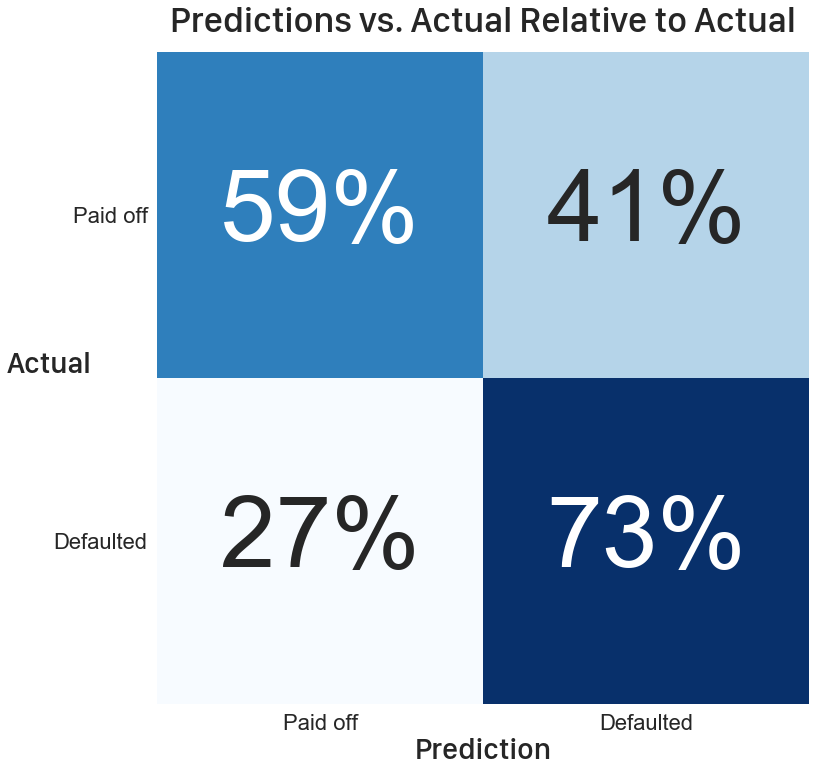

In [302]:
# Make Confusion Matrix with percentages
cm_test = confusion_matrix(y_test,lm.predict_proba(X_test)[:,1]>=.15789)
mat_confusion_test= cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
mat_confusion_test = mat_confusion_test.round(2)

plt.figure(dpi=300);
plt.figure(figsize=(12, 12));

sns.set(font_scale=2)
sns.heatmap(mat_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0%', cbar = False,
        annot_kws={"size": 100},
       xticklabels=['Paid off', 'Defaulted'],
       yticklabels=['Paid off', 'Defaulted']);
plt.xlabel('Prediction',fontname = '.SF Compact Display',fontsize = 30,fontweight = 'bold')
plt.ylabel('Actual',fontname = '.SF Compact Display',fontsize = 30,rotation = 0)
plt.yticks(rotation = 0)
plt.title('Predictions vs. Actual Relative to Actual',fontname = '.SF Compact Display',fontsize = 36,pad = 20);
plt.savefig('./graphs/confusion_matrix_rel_actual.png', dpi=300, bbox_inches = "tight")

<Figure size 1800x1200 with 0 Axes>

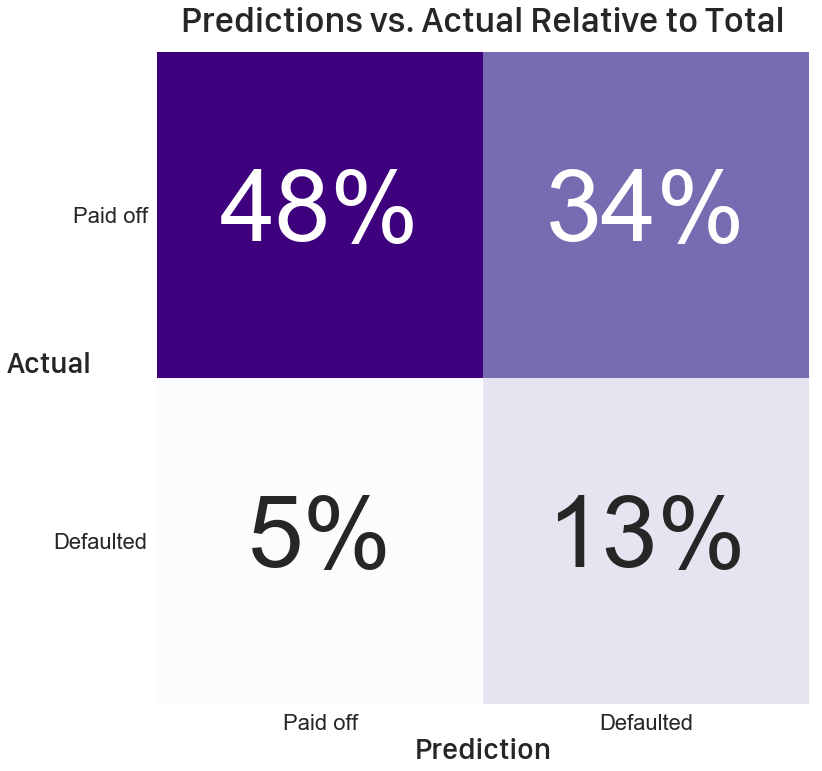

In [301]:
# Make Confusion Matrix with percentages
cm_test = confusion_matrix(y_test,lm.predict_proba(X_test)[:,1]>=.15789)
mat_confusion_test= cm_test.astype('float') / cm_test.sum()
mat_confusion_test = mat_confusion_test.round(2)

plt.figure(dpi=300);
plt.figure(figsize=(12, 12));

sns.set(font_scale=2)
sns.heatmap(mat_confusion_test, cmap=plt.cm.Purples, annot=True, square=True,
            fmt='.0%', cbar = False, annot_kws={"size": 100},
       xticklabels=['Paid off', 'Defaulted'],
       yticklabels=['Paid off', 'Defaulted']);
plt.xlabel('Prediction',fontname = '.SF Compact Display',fontsize = 30,fontweight = 'bold')
plt.ylabel('Actual',fontname = '.SF Compact Display',fontsize = 30,rotation = 0)
plt.yticks(rotation = 0)
plt.title('Predictions vs. Actual Relative to Total',fontname = '.SF Compact Display',fontsize = 36,pad = 20);
plt.savefig('./graphs/confusion_matrix_rel_total.png', dpi=300, bbox_inches = "tight")

In [ ]:
cm_test = confusion_matrix(y_test,lm.predict_proba(X_test)[:,1]>=.15789)
mat_confusion_test= cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
mat_confusion_test = mat_confusion_test.round(2)

plt.figure(dpi=80);
plt.figure(figsize=(12, 12));

sns.set(font_scale=1.5)
sns.heatmap(mat_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0%', cbar = False,
       xticklabels=['Paid off', 'Defaulted'],
       yticklabels=['Paid off', 'Defaulted']);
plt.xlabel('Prediction',fontname = '.SF Compact Display',fontsize = 30)
plt.ylabel('Actual',fontname = '.SF Compact Display',fontsize = 30,rotation = 0)
plt.yticks(rotation = 0)
plt.title('Optimal Threshold Confusion Matrix ',fontname = '.SF Compact Display',fontsize = 36,pad = 20);
plt.savefig('./graphs/confusion_matrix.png', dpi=300, bbox_inches = "tight")

Best Class Cutoff Threshold:  0.15789473684210525
Highest Profit from Model  131564529.8


<Figure size 480x320 with 0 Axes>

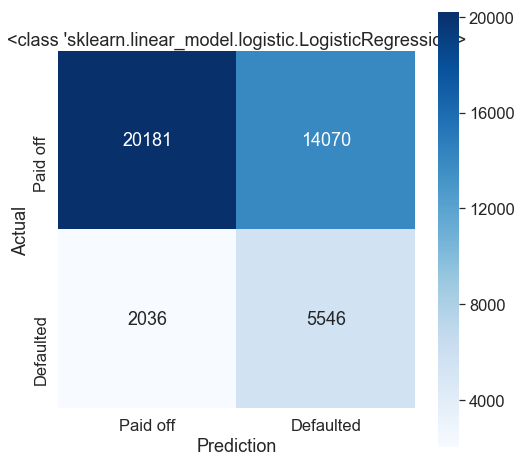

In [259]:
make_confusion_matrix(lm,X_test, y_test ,best_thresh,plot = True)
print('Best Class Cutoff Threshold: ', best_thresh)
print('Highest Profit from Model ', round(highest_profit* 5,2))


In [92]:
len(X_test)

41833

In [95]:
len(X_test)/(len(X_test) + len(X_train))

0.20000191238412146